### TPU Initialization

In [7]:
import tensorflow as tf

In [8]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)


print("Running on TPU")   
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

### Import of utilities

In [11]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 22.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.8/394.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.0/493.0 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.3/922.3 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.8 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━

In [12]:
import os
import random
import re
import json  
import spacy
import joblib
import numpy as np
import pandas as pd
from time import time
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [13]:
#### Random seed
def reset_random_seeds(CUR_SEED=42):
    os.environ['PYTHONHASHSEED'] = str(CUR_SEED)
    tf.random.set_seed(CUR_SEED)
    np.random.seed(CUR_SEED)
    random.seed(CUR_SEED)
    
reset_random_seeds()

In [6]:
from typing import Union, Callable, List
if tf.__version__[:3] > "2.5":
    from keras.engine import keras_tensor
else:
    from tensorflow.python.keras.engine import keras_tensor
    
Number = Union[
    float,
    int,
    np.float16,
    np.float32,
    np.float64,
    np.int8,
    np.int16,
    np.int32,
    np.int64,
    np.uint8,
    np.uint16,
    np.uint32,
    np.uint64,
]

TensorLike = Union[
    List[Union[Number, list]],
    tuple,
    Number,
    np.ndarray,
    tf.Tensor,
    tf.SparseTensor,
    tf.Variable,
    keras_tensor.KerasTensor,
]

In [7]:
def npairs_loss(y_true: TensorLike, y_pred: TensorLike) -> tf.Tensor:
    """Computes the npairs loss between `y_true` and `y_pred`.

    Npairs loss expects paired data where a pair is composed of samples from
    the same labels and each pairs in the minibatch have different labels.
    The loss takes each row of the pair-wise similarity matrix, `y_pred`,
    as logits and the remapped multi-class labels, `y_true`, as labels.

    The similarity matrix `y_pred` between two embedding matrices `a` and `b`
    with shape `[batch_size, hidden_size]` can be computed as follows:

    >>> a = tf.constant([[1, 2],
    ...                 [3, 4],
    ...                 [5, 6]], dtype=tf.float16)
    >>> b = tf.constant([[5, 9],
    ...                 [3, 6],
    ...                 [1, 8]], dtype=tf.float16)
    >>> y_pred = tf.matmul(a, b, transpose_a=False, transpose_b=True)
    >>> y_pred
    <tf.Tensor: shape=(3, 3), dtype=float16, numpy=
    array([[23., 15., 17.],
       [51., 33., 35.],
       [79., 51., 53.]], dtype=float16)>

    <... Note: constants a & b have been used purely for
    example purposes and have no significant value ...>

    See: http://www.nec-labs.com/uploads/images/Department-Images/MediaAnalytics/papers/nips16_npairmetriclearning.pdf

    Args:
      y_true: 1-D integer `Tensor` with shape `[batch_size]` of
        multi-class labels.
      y_pred: 2-D float `Tensor` with shape `[batch_size, batch_size]` of
        similarity matrix between embedding matrices.

    Returns:
      npairs_loss: float scalar.
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    # Expand to [batch_size, 1]
    #y_true = tf.expand_dims(y_true, -1)
    y_true = tf.cast(tf.equal(y_true, tf.transpose(y_true)), y_pred.dtype)
    y_true /= tf.math.reduce_sum(y_true, 1, keepdims=True)

    loss = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true)

    return tf.math.reduce_mean(loss)

In [14]:
train_dataset_daigt = pd.read_csv('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv',sep=",")
train_dataset_daigt

,text,label,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,human
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,human
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,human
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,human
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,human
...,...,...,...,...,...,...
65262,"Dear Senator,\n\nI am writing to you regarding...",1,Does the electoral college work?,text-davinci-003,True,davinci
65263,I remember the day distinctively. I was sittin...,1,Does the electoral college work?,text-davinci-003,True,davinci
65264,"Dear Senator, \n\nI am writing this letter to ...",1,Does the electoral college work?,text-davinci-003,True,davinci
65265,"Dear Senator,\n\nI am writing to urge you to e...",1,Does the electoral college work?,text-davinci-003,True,davinci


# Data Understanding

In [ ]:
print(train_dataset_daigt.info())
print(train_dataset_daigt[train_dataset_daigt['text'].duplicated()])
print(train_dataset_daigt.describe(include='object').T)

In [ ]:
# percentages of how many samples for each source

def statistic_for_model(train_dataset_daigt):
    statistics = {}
    just_ai_generated_text = train_dataset_daigt[train_dataset_daigt['label'] == 1]
    count_just_ai_generated = just_ai_generated_text.shape[0]
    my_sources = just_ai_generated_text['source'].unique()
    for source in my_sources:
        count_for_source = just_ai_generated_text[just_ai_generated_text['source'] == source].shape[0]
        statistics[source] = round(count_for_source/count_just_ai_generated, 6)
    return statistics
    
statistics_for_model_list = statistic_for_model(train_dataset_daigt)
statistics_for_model_list

In [15]:
# To work better with our dataset, we decided to split it in sub-dataset, where the split is given by the prompt
# This choice was made in order to understand better the distribution of the dataset and to try to balance it

my_prompts = train_dataset_daigt['prompt_name'].unique()
sub_dataset = {}
for prompt in my_prompts:
    sub_dataset[prompt] = train_dataset_daigt[train_dataset_daigt['prompt_name'] == prompt]
    
sub_dataset_car_free_prompt = sub_dataset['Car-free cities']
print(sub_dataset_car_free_prompt)

for prompt in my_prompts:
    print(sub_dataset[prompt].shape)

                                                    text  label  \
1168   Cars have been around for awhile and they have...      0   
1169   Have you ever thought what it would be like no...      0   
1170   What you are about to read is going to give yo...      0   
1171   cars have many flaws nd and in this day and ag...      0   
1172   There are many advantages of limiting car usag...      0   
...                                                  ...    ...   
64662  It was a hot summer day in the city and I coul...      1   
64663  Sitting in the back seat of my moms car, I oft...      1   
64664  It was a blazing hot summer day in June, and I...      1   
64665  It was a typical weekend morning. I woke up ea...      1   
64666  It all started on a hot summer daythe kind of ...      1   

           prompt_name            source  RDizzl3_seven    model  
1168   Car-free cities   persuade_corpus           True    human  
1169   Car-free cities   persuade_corpus           True    hu

In [16]:
# how many samples for each source? 

def compute_count_texts_for_source(train_dataset_daigt):
    computed_counts = {}
    just_ai_generated_text = train_dataset_daigt[train_dataset_daigt['label'] == 1]
    my_sources = just_ai_generated_text['source'].unique()
    for source in my_sources:
        computed_counts[source] = just_ai_generated_text[just_ai_generated_text['source'] == source].shape[0]
    return computed_counts

# This function is used to compute how many samples for each source are present in the dataset during the undersampling.
def update_count_texts_for_source(count_for_source, samples_to_drop_for_source):
    updated_counts = {}
    for source in count_for_source.keys():
        count_samples_to_remove = 0
        if source in samples_to_drop_for_source:
            count_samples_to_remove = samples_to_drop_for_source[source]
        updated_counts[source] = count_for_source[source] - count_samples_to_remove
    return updated_counts
    
print(compute_count_texts_for_source(train_dataset_daigt))

{'mistral7binstruct_v2': 2421, 'llama_70b_v1': 1172, 'chat_gpt_moth': 2421, 'darragh_claude_v7': 1000, 'darragh_claude_v6': 1000, 'mistral7binstruct_v1': 2420, 'llama2_chat': 2418, 'falcon_180b_v1': 1043, 'radek_500': 500, 'NousResearch/Llama-2-7b-chat-hf': 400, 'mistralai/Mistral-7B-Instruct-v0.1': 399, 'palm-text-bison1': 349, 'cohere-command': 350, 'radekgpt4': 200, 'train_essays': 3, 'kingki19_palm': 1384, 'Intel-neural-chat-7b-v3-1_LLMEssays_v1': 3309, 'Mistral7B_CME_v7': 4890, 'llama_falcon_v3_llama_70b': 3500, 'llama_falcon_v3_falcon_180b': 3493, 'nima_gpt4': 1040, 'text-ada-001': 692, 'text-babbage-001': 698, 'text-curie-001': 696, 'text-davinci-001': 700, 'text-davinci-002': 699, 'text-davinci-003': 700}


# Data Preparation

In [17]:
def remove_all_samples(train_dataset_daigt, ai_dataset, samples_to_drop_for_source):
    for source in samples_to_drop_for_source.keys():
        indexes_to_drop = ai_dataset[ai_dataset['source'] == source].sample(n=samples_to_drop_for_source[source]).index
        ai_dataset = ai_dataset.drop(indexes_to_drop)
        train_dataset_daigt = train_dataset_daigt.drop(indexes_to_drop)
    return (ai_dataset, train_dataset_daigt)

# To drop the right number of sample for each source and to not create more biases within the dataset, we decide at each iteration from which source to remove the samples. 
# The source is chosen based on how many samples are currently present in the dataset, but taking into account how many we have already decided to drop from that source.
# The sorce with the highest number of samples is then selected.

# For reasons of optimization and, therefore, performance, the samples are removed all at once at the end and the counting of the number of samples per source is done without updating the datasets but only updating the dictionaries.

def simplified_try_to_balance_by_model_and_remove(ai_dataset, human_dataset_count, train_dataset_daigt):
    threesold = 300
    counts_for_sources = compute_count_texts_for_source(train_dataset_daigt)
    counts_for_sources_in_prompt = compute_count_texts_for_source(ai_dataset)
    current_counts_for_sources = counts_for_sources
    difference_between_datasets = ai_dataset.shape[0] - human_dataset_count
    samples_to_drop_for_source = {}
    for i in range(0, difference_between_datasets):
        ordered_counts = dict(sorted(current_counts_for_sources.items(), key=lambda item: item[1], reverse=True))
        for current_max_count_source in ordered_counts.keys():
            if current_max_count_source in ai_dataset['source'].values and ordered_counts[current_max_count_source] >= threesold and samples_to_drop_for_source.get(current_max_count_source, 0) < counts_for_sources_in_prompt[current_max_count_source]:
                if current_max_count_source not in samples_to_drop_for_source:
                    samples_to_drop_for_source[current_max_count_source] = 0
                samples_to_drop_for_source[current_max_count_source] += 1
                current_counts_for_sources = update_count_texts_for_source(counts_for_sources, samples_to_drop_for_source)
                break
    return remove_all_samples(train_dataset_daigt, ai_dataset, samples_to_drop_for_source)

In [18]:
# What we want to do is to keep an (semi) equal number of sample for each different prompt.
# If we have more human-sample, we just drop the surplus.
# If we have more ai-generated-sample, we want to drop the surplus but paying attention on the source of the text.
# To not create more biases within the dataset, we prefer to drop the samples of the sources with a higher number of samples in the dataset.


for prompt in my_prompts:
    print(prompt)
    ai_dataset = sub_dataset[prompt][sub_dataset[prompt]['label'] == 1]
    human_dataset = sub_dataset[prompt][sub_dataset[prompt]['label'] == 0]
    if human_dataset.shape[0] == ai_dataset.shape[0]:
        continue
    elif human_dataset.shape[0] > ai_dataset.shape[0]:
        human_dataset = human_dataset.sample(n=ai_dataset.shape[0])
    else:
        ai_dataset, train_dataset_daigt = simplified_try_to_balance_by_model_and_remove(ai_dataset, human_dataset.shape[0], train_dataset_daigt)
    sub_dataset[prompt] = pd.concat([ai_dataset, human_dataset])
    sub_dataset[prompt] = sub_dataset[prompt].sample(n = sub_dataset[prompt].shape[0])

Phones and driving
Car-free cities
Summer projects
"A Cowboy Who Rode the Waves"
Mandatory extracurricular activities
Exploring Venus
Facial action coding system
The Face on Mars
Community service
Grades for extracurricular activities
Driverless cars
Does the electoral college work?
Cell phones at school
Distance learning
Seeking multiple opinions


In [ ]:
for prompt in my_prompts:
    count_human_generated = sub_dataset[prompt][sub_dataset[prompt]['label'] == 0].shape[0]
    count_ai_generated = sub_dataset[prompt][sub_dataset[prompt]['label'] == 1].shape[0]
    print('***' + prompt + '***')
    print(count_ai_generated)
    print(count_human_generated)

In [19]:
# At the end of the undersampling process, we merge again all the sub_dataset to work on a single updated dataset from now on.

all_sub_datasets = pd.DataFrame()
for prompt in my_prompts:
    all_sub_datasets = pd.concat([all_sub_datasets, sub_dataset[prompt]], ignore_index=True)
print(compute_count_texts_for_source(all_sub_datasets))
print(all_sub_datasets.shape[0])

{'llama_70b_v1': 1141, 'darragh_claude_v7': 1000, 'falcon_180b_v1': 1043, 'darragh_claude_v6': 1000, 'mistral7binstruct_v1': 1414, 'nima_gpt4': 1040, 'chat_gpt_moth': 1414, 'llama2_chat': 1414, 'mistral7binstruct_v2': 1414, 'NousResearch/Llama-2-7b-chat-hf': 400, 'radek_500': 500, 'kingki19_palm': 1066, 'mistralai/Mistral-7B-Instruct-v0.1': 399, 'text-davinci-001': 700, 'cohere-command': 350, 'text-babbage-001': 698, 'text-ada-001': 692, 'text-curie-001': 696, 'text-davinci-002': 699, 'palm-text-bison1': 349, 'radekgpt4': 200, 'text-davinci-003': 700, 'train_essays': 3, 'Intel-neural-chat-7b-v3-1_LLMEssays_v1': 1067, 'llama_falcon_v3_falcon_180b': 1067, 'llama_falcon_v3_llama_70b': 1067, 'Mistral7B_CME_v7': 1067}
45200


In [20]:
# Our dataset contains symbols and characters that are not numbers or letters, for this reason, we prefer to remove those kind of chars.
# In particular, we are afraid that, if too human-correlated, those chars can be associated by the network directly to a label rather than to another one.

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

all_sub_datasets['text'] = all_sub_datasets['text'].apply(remove_emoji)

print(all_sub_datasets)

EMOTICONS = {
u":‑)":"Happy face or smiley",
u":)":"Happy face or smiley",
u":-]":"Happy face or smiley",
u":]":"Happy face or smiley",
u":-3":"Happy face smiley",
u":3":"Happy face smiley",
u":->":"Happy face smiley",
u":>":"Happy face smiley",
u"8-)":"Happy face smiley",
u":o)":"Happy face smiley",
u":-}":"Happy face smiley",
u":}":"Happy face smiley",
u":-)":"Happy face smiley",
u":c)":"Happy face smiley",
u":^)":"Happy face smiley",
u"=]":"Happy face smiley"
}

def remove_emoticons(text):
    pattern = re.compile(u'(' + u'|'.join(re.escape(k) for k in EMOTICONS.keys()) + u')')
    updated_text = pattern.sub(r'', text)
    return updated_text

all_sub_datasets['text'] = all_sub_datasets['text'].apply(remove_emoticons)

print(all_sub_datasets)


                                                    text  label  \
0      Gun control is an issue that has been at the f...      1   
1      Drivers Should Not Use Cell Phones in Any Capa...      1   
2      "I think that we do need stronger privacy prot...      1   
3      Drivers should not be allowed to use cell phon...      1   
4      Cell phones has become very popular over the p...      0   
...                                                  ...    ...   
45195  When people are asking for advice,why are they...      0   
45196   Positive Attitude: Agree or Disagree\n\nPosit...      1   
45197  We all know how important it is to have a posi...      1   
45198  Hey there!  So, I've been thinking a lot about...      1   
45199  When people ask for advice, they sometimes tal...      0   

                     prompt_name                source  RDizzl3_seven    model  
0             Phones and driving          llama_70b_v1          False    llama  
1             Phones and driving 

# Extraction of linguistic features

The object english_model provides access to all natural language processing components. In particular, spacy.load loads the English language model that contains pre-trained linguistic information for English, including part-of-speech recognition, syntactic parsing, entity recognition, and more. After loading the model, you can use the object to analyze text, obtain linguistic information, and perform various NLP tasks.

The english_model(text) statement returns a spaCy Doc object. A Doc object represents a parsed textual document, which contains linguistic information extracted from the text provided as input.
doc = english_model(text)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [ ]:
#spacy.require_gpu()
english_model = spacy.load("en_core_web_sm")

#1: Lengths of sentences and paragraphs:
def calculate_average_sentence_length(list_of_doctexts):
    list_of_lengths = []
    sum_of_lengths = 0
    count_lengths = 0
    for doc in list_of_doctexts:
        for sent in doc.sents:
            count_lengths += 1
            sum_of_lengths += len(sent)
        list_of_lengths.append(sum_of_lengths/count_lengths)
    return list_of_lengths

def calculate_average_paragraph_lengths(list_of_doctexts):
    list_of_lengths = []
    sum_of_lengths = 0
    for doc in list_of_doctexts:
        paragraph_lengths = []
        current_paragraph_length = 0
        for token in doc:
            if token.is_space and token.text == "\n":
                paragraph_lengths.append(current_paragraph_length)
                current_paragraph_length = 0
            else:
                current_paragraph_length += 1
        paragraph_lengths.append(current_paragraph_length)
        list_of_lengths.append(sum(paragraph_lengths)/len(paragraph_lengths))
    return list_of_lengths
    
#2. Use of Punctuation:
def calculate_punctuation_frequency(list_of_doctexts):
    list_of_frequencys = []
    for doc in list_of_doctexts:
        punctuation_frequency = len([token for token in doc if token.is_punct])
        list_of_frequencys.append(punctuation_frequency)
    return list_of_frequencys

#3. Stop Words Report:
def calculate_stopword_ratio(list_of_doctexts):
    list_of_ratios = []
    for doc in list_of_doctexts:
        total_words = len([token for token in doc if token.is_alpha])
        stop_words = len([token for token in doc if token.is_stop])
        stopword_ratio = stop_words / total_words if total_words > 0 else 0
        list_of_ratios.append(stopword_ratio)
    return list_of_ratios


Extracting features from the training data using a sparse vectorizer
TfidfVectorizer is a class in scikit-learn that combines two main concepts: the Bag of Words (BoW) representation and normalization through Term Frequency-Inverse Document Frequency (TF-IDF).
- Bag of Words (BoW): In the context of Natural Language Processing (NLP), the "Bag of Words" representation treats a document as an unordered set of words, ignoring the structure and order of the original words.
    
TfidfVectorizer creates a count vector for each document, where each element of the vector represents the frequency of a specific word in the text. This count vector is referred to as "Bag of Words."
- Term Frequency-Inverse Document Frequency (TF-IDF):
    - Term Frequency (TF) measures the frequency of a word in a specific document. For example, a frequently occurring word will have a higher TF.
    - Inverse Document Frequency (IDF) measures the importance of a word across the entire corpus. Common words appearing in many documents will have a low IDF.
    
TF-IDF is the product of TF and IDF and is designed to give more weight to words that are important in a specific document but not common across the corpus. This helps mitigate the effect of common words that may not contribute significantly to the informative content.
TfidfVectorizer combines both of these concepts. When using this class, you get a vector representation of the text where words are weighted based on their frequency in documents and their importance in the overall corpus. This can be particularly useful to reduce the impact of common words that may not contribute significantly to the informative content of the text.


In [ ]:
def vectorize_dataset(dataset, vocabulary = None):
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english", max_features=10000, vocabulary=vocabulary
    )

    csr_matrix = vectorizer.fit_transform(dataset)
    duration_train = time() - t0
    print(duration_train)
    
    print(csr_matrix.shape)
    print(csr_matrix)
    
    return (vectorizer.vocabulary_, csr_matrix)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(all_sub_datasets["text"], all_sub_datasets['label'], test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
f = open('/kaggle/input/svm-model/vocabulary.json')
data = json.load(f)

f.close()

In [ ]:
vocabulary, csr_matrix_train = vectorize_dataset(x_train, data)
vocabulary, csr_matrix_val = vectorize_dataset(x_val, data)
vocabulary, csr_matrix_test = vectorize_dataset(x_test, data)

In [ ]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

vocabulary_file = open("/kaggle/working/vocabulary.json", "w")  
json.dump(vocabulary, vocabulary_file, indent = 6, cls=NpEncoder)  
vocabulary_file.close()  

In [ ]:
features_dataset = pd.DataFrame.sparse.from_spmatrix(csr_matrix_train)
features_dataset_val = pd.DataFrame.sparse.from_spmatrix(csr_matrix_val)
features_dataset_test = pd.DataFrame.sparse.from_spmatrix(csr_matrix_test)
print(features_dataset)

In [ ]:
# Computation of the doc from the english_model. This computation is made in a cell by itself because it
# takes a lot of time, so we prefer to compute those important resources in advance and trying to parallelize
# the overall computation.

def compute_docs_from_dataset(dataset):
    t0 = time()
    docs = list(english_model.pipe(dataset, batch_size=64))
    duration_train = time() - t0
    print(duration_train)
    return docs

In [ ]:
docs_from_dataset_train = compute_docs_from_dataset(x_train)
docs_from_dataset_val = compute_docs_from_dataset(x_val)
docs_from_dataset_test = compute_docs_from_dataset(x_test)

In [ ]:
x_train = x_train.reset_index().drop(["index"], axis=1)
x_val = x_val.reset_index().drop(["index"], axis=1)
x_test = x_test.reset_index().drop(["index"], axis=1)

In [ ]:
def add_statistics_columns(features_dataset, dataset, docs_from_dataset):
    features_dataset['len_text'] = dataset['text'].apply(len)
    features_dataset['sentence_lengths'] = calculate_average_sentence_length(docs_from_dataset)
    features_dataset['paragraph_lengths'] = calculate_average_paragraph_lengths(docs_from_dataset)
    features_dataset['punctuation_frequency'] = calculate_punctuation_frequency(docs_from_dataset)
    features_dataset['stopword_ratio'] = calculate_stopword_ratio(docs_from_dataset)

    features_dataset.columns = features_dataset.columns.astype(str)
    
    print(features_dataset)

In [ ]:
add_statistics_columns(features_dataset, x_train, docs_from_dataset_train)
add_statistics_columns(features_dataset_val, x_val, docs_from_dataset_val)
add_statistics_columns(features_dataset_test, x_test, docs_from_dataset_test)

# Data Modeling and Data Evaluation

### SVM MODEL (First part of the architecture)

In [17]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sb

In [19]:
def make_confusion_matrix(cf, categories='auto', cbar=True, cmap='Blues', title=None):
    group_counts = [f'{value}\n' for value in cf.flatten()]

    box_labels = [f'{v1}'.strip() for v1 in group_counts]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    sb.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if title:
        plt.title(title)

In [ ]:
t0 = time()
svm_model = SVC(kernel='linear')
svm_model.fit(features_dataset, y_train)
duration_train = time() - t0
print(duration_train)

joblib.dump(svm_model, '/kaggle/working/svm_model.joblib')

t0 = time()
y_val_pred = svm_model.predict(features_dataset_val)
duration_train = time() - t0
print(duration_train)
print('Classification metrics: ')
print(classification_report(y_val, y_val_pred))
make_confusion_matrix(confusion_matrix(y_val, y_val_pred), categories=categories, cmap='binary')

In [ ]:
y_val_pred = np.array(y_val_pred).reshape((6328,1))
np.savetxt('/kaggle/working/svm_numpy_val_outputs.csv', y_val_pred, delimiter=',')

t0 = time()
y_train_pred = svm_model.predict(features_dataset)
make_confusion_matrix(confusion_matrix(y_train, y_train_pred), categories=categories, cmap='binary')
y_train_pred = np.array(y_train_pred).reshape((25312,1))
np.savetxt('/kaggle/working/svm_numpy_train_outputs.csv', y_train_pred, delimiter=',')
duration_train = time() - t0
print(duration_train)

y_test_pred = svm_model.predict(features_dataset_test)
make_confusion_matrix(confusion_matrix(y_test, y_test_pred), categories=categories, cmap='binary')
y_test_pred = np.array(y_test_pred).reshape((13560,1))
np.savetxt('/kaggle/working/svm_numpy_test_outputs.csv', y_test_pred, delimiter=',')

### GPT-BERT MODELS (Second part of the architecture)

In [20]:
from transformers import TFBertModel, TFGPT2Model, AutoTokenizer
 
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
gpt_tokenizer = AutoTokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tokenizer_config.json: 100%|██████████| 29.0/29.0 [00:00<00:00, 121kB/s]
config.json: 100%|██████████| 570/570 [00:00<00:00, 2.77MB/s]
vocab.txt: 100%|██████████| 213k/213k [00:00<00:00, 8.62MB/s]
tokenizer.json: 100%|██████████| 436k/436k [00:00<00:00, 30.4MB/s]
config.json: 100%|██████████| 665/665 [00:00<00:00, 2.41MB/s]
vocab.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 28.1MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 26.3MB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 19.2MB/s]


In [22]:
tokens_length = 512
projection_units = 64
learning_rate = 0.001
temperature = 0.05
dropout_rate = 0.5
num_epochs = 10

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(all_sub_datasets["text"], all_sub_datasets['label'], test_size=0.3, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [23]:
if gpt_tokenizer.pad_token is None:
    gpt_tokenizer.add_special_tokens({'pad_token': '0'})

In [24]:
def tokenize_dataset(tokenizer, dataset):
    tokenized_dataset = tokenizer.batch_encode_plus(
        dataset.to_list(),
        add_special_tokens= True,
        max_length=tokens_length,
        padding='max_length', truncation=True,
        return_attention_mask=True,
        return_tensors='tf')
    return tokenized_dataset

In [25]:
x_train_bert_tokenization = tokenize_dataset(bert_tokenizer, x_train)
x_train_gpt_tokenization = tokenize_dataset(gpt_tokenizer, x_train)

x_val_bert_tokenization = tokenize_dataset(bert_tokenizer, x_val)
x_val_gpt_tokenization = tokenize_dataset(gpt_tokenizer, x_val)

x_test_bert_tokenization = tokenize_dataset(bert_tokenizer, x_test)
x_test_gpt_tokenization = tokenize_dataset(gpt_tokenizer, x_test)

print(x_train_bert_tokenization)
print(x_train_gpt_tokenization)

{'input_ids': <tf.Tensor: shape=(25312, 512), dtype=int32, numpy=
array([[  101,  1109,  6627, ...,     0,     0,     0],
       [  101,  4403,   117, ...,     0,     0,     0],
       [  101,  1332,  1128, ...,     0,     0,     0],
       ...,
       [  101, 12983, 22733, ...,  5050,  1137,   102],
       [  101,  1109,  6438, ...,     0,     0,     0],
       [  101,   146,  2676, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(25312, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(25312, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

In [27]:
train_input = {"bert_input_word_ids": x_train_bert_tokenization['input_ids'], 
               "gpt_input_word_ids": x_train_gpt_tokenization['input_ids']}

val_input = {"bert_input_word_ids": x_val_bert_tokenization['input_ids'], 
               "gpt_input_word_ids": x_val_gpt_tokenization['input_ids']}

test_input = {"bert_input_word_ids": x_test_bert_tokenization['input_ids'], 
               "gpt_input_word_ids": x_test_gpt_tokenization['input_ids']}

In [28]:
def build_model():
    bert_model = TFBertModel.from_pretrained('bert-base-cased')
    gpt_model = TFGPT2Model.from_pretrained('gpt2')
    bert_model._name = "bert_patterns_recognizer"
    gpt_model._name = "gpt_patterns_recognizer"
    
    bert_input_word_ids = tf.keras.Input(shape=(tokens_length,), dtype=tf.int32, name="bert_input_word_ids")
    gpt_input_word_ids = tf.keras.Input(shape=(tokens_length,), dtype=tf.int32, name="gpt_input_word_ids")
    
    bert_embedding = bert_model([bert_input_word_ids])[0]
    gpt_embedding = gpt_model([gpt_input_word_ids])[0]

    output = tf.keras.layers.Concatenate()([bert_embedding, gpt_embedding])
       
    model = tf.keras.Model(inputs=[bert_input_word_ids, gpt_input_word_ids], outputs=output)
    model.compile()  
    return model 

In [29]:
y_train = y_train.to_numpy().reshape((25312,1))
y_val = y_val.to_numpy().reshape((6328,1))
y_test = y_test.to_numpy().reshape((13560,1))

In [30]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature
    
    def __call__(self, labels, feature_vectors, sample_weight):
        normalized_feature_vectors = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(
            tf.matmul(normalized_feature_vectors, tf.transpose(normalized_feature_vectors)),
            self.temperature
        )

        return npairs_loss(labels, logits)

def add_projection_head(encoder):
    bert_input_word_ids = tf.keras.Input(shape=(tokens_length,), dtype=tf.int32, name="bert_input_word_ids")
    gpt_input_word_ids = tf.keras.Input(shape=(tokens_length,), dtype=tf.int32, name="gpt_input_word_ids")
    #encoder.trainable = False
    features = encoder([bert_input_word_ids, gpt_input_word_ids])
    features = layers.Flatten()(features)
    outputs = tf.keras.layers.Dense(projection_units, activation="relu")(features)
    model = tf.keras.Model(
        [bert_input_word_ids, gpt_input_word_ids], outputs, name="encoder-with-projection"
    )
    return model

In [31]:
checkpoint_path = "/kaggle/working/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [33]:
with strategy.scope():
    encoder = build_model()
    encoder.summary()
    encoder_with_projection_head = add_projection_head(encoder)
    encoder_with_projection_head.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=SupervisedContrastiveLoss(temperature),
    )

encoder_with_projection_head.summary()
earlystopCallback = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,verbose=1)

history = encoder_with_projection_head.fit(
    x=train_input, y=y_train, batch_size=16*strategy.num_replicas_in_sync, epochs=num_epochs, callbacks=[earlystopCallback, checkpointCallback]
)

model.safetensors: 100%|██████████| 436M/436M [00:02<00:00, 214MB/s] 
2024-02-06 08:53:05.853836: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:53:05.853992: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel fr

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input_word_ids (Input  [(None, 512)]                0         []                            
 Layer)                                                                                           
                                                                                                  
 gpt_input_word_ids (InputL  [(None, 512)]                0         []                            
 ayer)                                                                                            
                                                                                                  
 bert_patterns_recognizer (  TFBaseModelOutputWithPooli   1083102   ['bert_input_word_ids[0][0]'] 
 TFBertModel)                ngAndCrossAttentions(last_   72                                  

2024-02-06 08:53:49.934838: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:53:49.952786: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:53:49.970711: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:53:49.987893: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:53:50.005415: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:53:50.022804: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:53:50.040037: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

2024-02-06 08:54:45.550158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2024-02-06 08:54:51.135996: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:54:51.139255: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:54:51.139411: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:54:51.139540: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:54:51.139709: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:54:51.139847: E ./tensorflow/compiler/xla/stream_executor/st

  1/198 [..............................] - ETA: 7:27:38 - loss: 7.6605

2024-02-06 08:56:06.416257: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:56:06.416417: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:56:06.416841: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:56:06.417055: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  2/198 [..............................] - ETA: 1:50 - loss: 5.2163   

2024-02-06 08:56:06.979610: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:56:06.980007: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  3/198 [..............................] - ETA: 1:50 - loss: 4.4017

2024-02-06 08:56:07.543980: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  9/198 [>.............................] - ETA: 1:46 - loss: 3.3140

2024-02-06 08:56:10.919302: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 18/198 [=>............................] - ETA: 1:41 - loss: 3.0434

2024-02-06 08:56:16.004299: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 36/198 [====>.........................] - ETA: 1:31 - loss: 2.9080

2024-02-06 08:56:26.153991: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:56:26.154105: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-06 08:56:26.154246: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 45/198 [=====>........................] - ETA: 1:26 - loss: 2.8809

2024-02-06 08:56:31.247503: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 95/198 [=============>................] - ETA: 58s - loss: 2.8212

2024-02-06 08:56:59.572615: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


198/198 [==============================] - ETA: 0s - loss: 2.7561WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



Epoch 1: saving model to /kaggle/working/training_1/cp.ckpt
198/198 [==============================] - 344s 1s/step - loss: 2.7561
Epoch 2/10
198/198 [==============================] - ETA: 0s - loss: 2.1684WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



Epoch 2: saving model to /kaggle/working/training_1/cp.ckpt
198/198 [==============================] - 148s 750ms/step - loss: 2.1684
Epoch 3/10
198/198 [==============================] - ETA: 0s - loss: 2.1240WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



Epoch 3: saving model to /kaggle/working/training_1/cp.ckpt
198/198 [==============================] - 144s 727ms/step - loss: 2.1240
Epoch 4/10
198/198 [==============================] - ETA: 0s - loss: 2.1127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



Epoch 4: saving model to /kaggle/working/training_1/cp.ckpt
198/198 [==============================] - 155s 785ms/step - loss: 2.1127
Epoch 5/10
198/198 [==============================] - ETA: 0s - loss: 2.1161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



Epoch 5: saving model to /kaggle/working/training_1/cp.ckpt
198/198 [==============================] - 156s 791ms/step - loss: 2.1161
Epoch 6/10
198/198 [==============================] - ETA: 0s - loss: 2.1165WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



Epoch 6: saving model to /kaggle/working/training_1/cp.ckpt
198/198 [==============================] - 148s 747ms/step - loss: 2.1165
Epoch 7/10
198/198 [==============================] - ETA: 0s - loss: 2.1121WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



Epoch 7: saving model to /kaggle/working/training_1/cp.ckpt
198/198 [==============================] - 155s 785ms/step - loss: 2.1121
Epoch 8/10
198/198 [==============================] - ETA: 0s - loss: 2.1134WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



Epoch 8: saving model to /kaggle/working/training_1/cp.ckpt
198/198 [==============================] - 156s 788ms/step - loss: 2.1134
Epoch 9/10
198/198 [==============================] - ETA: 0s - loss: 2.1117WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



Epoch 9: saving model to /kaggle/working/training_1/cp.ckpt
198/198 [==============================] - 241s 1s/step - loss: 2.1117
Epoch 10/10
198/198 [==============================] - ETA: 0s - loss: 2.1128WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss



Epoch 10: saving model to /kaggle/working/training_1/cp.ckpt
198/198 [==============================] - 198s 1s/step - loss: 2.1128


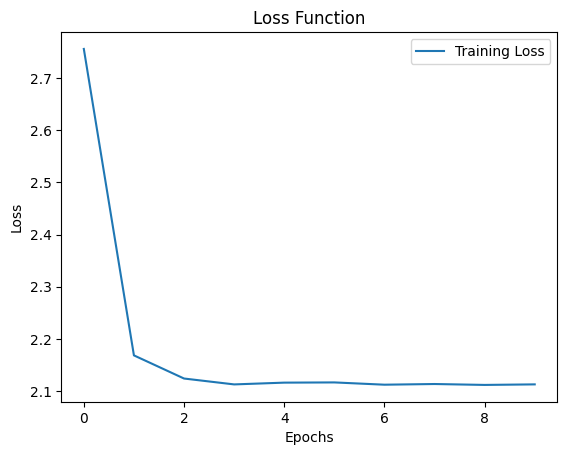

In [34]:
# CALCOLO GRAFICO
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
val_predictions_encoder = encoder.predict(val_input, batch_size=16*strategy.num_replicas_in_sync)

2024-02-06 09:41:27.010393: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


50/50 [==============================] - 42s 507ms/step


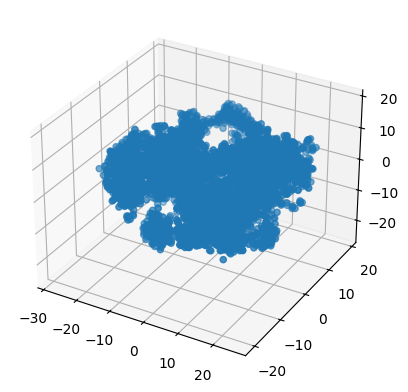

In [38]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Carica il tuo tensore tridimensionale dalla tua batch
tensor = val_predictions_encoder

# Applica t-SNE per ridurre la dimensionalità a 3 dimensioni
tsne = TSNE(n_components=3, random_state=42)
subset_tensor_3d = tsne.fit_transform(tensor.reshape(-1, tensor.shape[1] * tensor.shape[2]))

# Plotta i punti tridimensionali
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(subset_tensor_3d[:, 0], subset_tensor_3d[:, 1], subset_tensor_3d[:, 2])


In [39]:
np.savetxt('subset.tsv', subset_tensor_3d, delimiter='\t')
np.savetxt('labels.tsv', y_val, delimiter='\t')

In [40]:
def create_classifier(encoder):
    for layer in encoder.layers:
        layer.trainable = False
     
    bert_input_word_ids = tf.keras.Input(shape=(tokens_length,), dtype=tf.int32, name="bert_input_word_ids")
    gpt_input_word_ids = tf.keras.Input(shape=(tokens_length,), dtype=tf.int32, name="gpt_input_word_ids")
    features = encoder([bert_input_word_ids, gpt_input_word_ids])
    features = layers.Flatten()(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(1, activation="sigmoid")(features)

    model = keras.Model(inputs=[bert_input_word_ids, gpt_input_word_ids], outputs=outputs, name="classifier-gpt-bert-representations")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(), 
                 keras.metrics.Precision(), keras.metrics.Recall()],
    )
    return model

In [41]:
checkpoint_path = "/kaggle/working/training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [42]:
with strategy.scope():
    classifier = create_classifier(encoder)
    classifier.summary()


earlystopCallback = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

history_classifier = classifier.fit(train_input, y_train, batch_size=16*strategy.num_replicas_in_sync, epochs=6, validation_data = (val_input, y_val), callbacks=[earlystopCallback, checkpointCallback])


Model: "classifier-gpt-bert-representations"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input_word_ids (Input  [(None, 512)]                0         []                            
 Layer)                                                                                           
                                                                                                  
 gpt_input_word_ids (InputL  [(None, 512)]                0         []                            
 ayer)                                                                                            
                                                                                                  
 model (Functional)          (None, 512, 1536)            2327500   ['bert_input_word_ids[0][0]', 
                                                          80    

2024-02-06 10:02:36.041781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


198/198 [==============================] - ETA: 0s - loss: 0.3284 - binary_accuracy: 0.9953 - auc: 0.9964 - precision: 0.9959 - recall: 0.9948

2024-02-06 10:03:54.388061: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.



Epoch 1: saving model to /kaggle/working/training_2/cp.ckpt
198/198 [==============================] - 143s 476ms/step - loss: 0.3284 - binary_accuracy: 0.9953 - auc: 0.9964 - precision: 0.9959 - recall: 0.9948 - val_loss: 4.7727 - val_binary_accuracy: 0.9912 - val_auc: 0.9911 - val_precision: 0.9939 - val_recall: 0.9881
Epoch 2/6
198/198 [==============================] - ETA: 0s - loss: 0.0804 - binary_accuracy: 0.9997 - auc: 0.9997 - precision: 0.9997 - recall: 0.9998
Epoch 2: saving model to /kaggle/working/training_2/cp.ckpt
198/198 [==============================] - 48s 242ms/step - loss: 0.0804 - binary_accuracy: 0.9997 - auc: 0.9997 - precision: 0.9997 - recall: 0.9998 - val_loss: 4.9228 - val_binary_accuracy: 0.9908 - val_auc: 0.9908 - val_precision: 0.9945 - val_recall: 0.9868
Epoch 3/6
198/198 [==============================] - ETA: 0s - loss: 0.0891 - binary_accuracy: 0.9997 - auc: 0.9997 - precision: 0.9998 - recall: 0.9996
Epoch 3: saving model to /kaggle/working/trainin

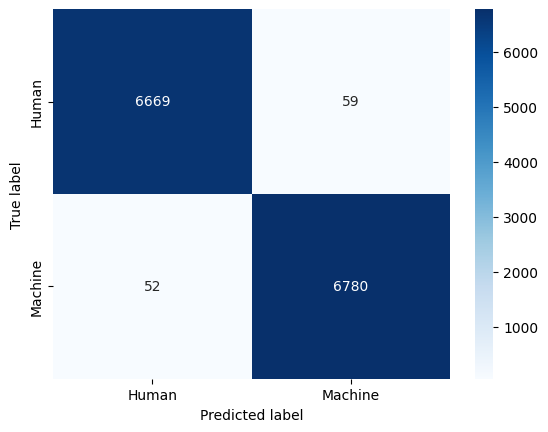

In [59]:
predictions_train_class = classifier.predict(train_input, batch_size=16*strategy.num_replicas_in_sync)
predictions_train_class = [1 if pred > 0.5 else 0 for pred in predictions_train_class]
make_confusion_matrix(confusion_matrix(y_test, predictions_test_class), categories=categories)

In [52]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

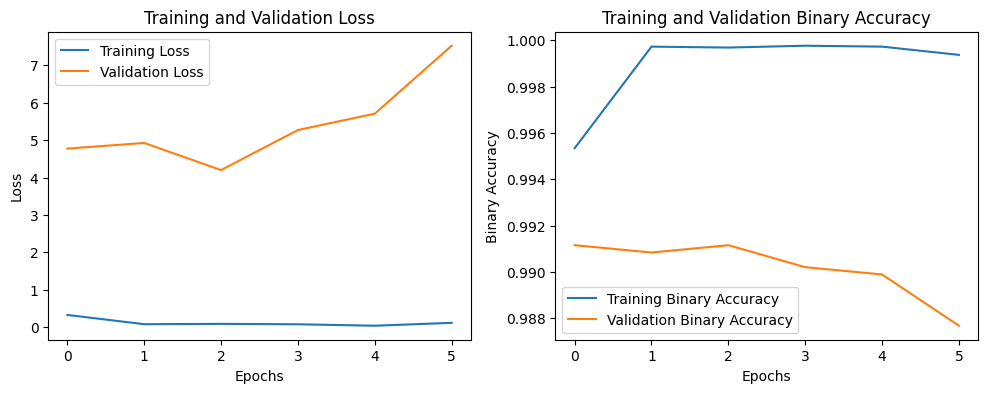

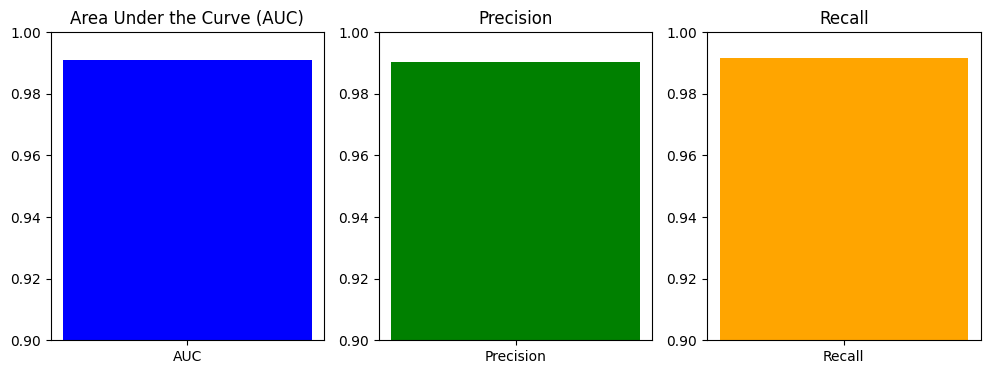

In [55]:
roc_auc = roc_auc_score(y_val, predictions_val_class)
precision = precision_score(y_val, predictions_val_class)
recall = recall_score(y_val, predictions_val_class)

# Plot della loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot della binary_accuracy
plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['binary_accuracy'], label='Training Binary Accuracy')
plt.plot(history_classifier.history['val_binary_accuracy'], label='Validation Binary Accuracy')
plt.title('Training and Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()

plt.show()

# Plot dell'AUC, della Precision e del Recall
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.bar(['AUC'], [roc_auc], color=['blue'])
plt.ylim(0.9, 1)  # Imposta i limiti del range per l'AUC
plt.title('Area Under the Curve (AUC)')

plt.subplot(1, 3, 2)
plt.bar(['Precision'], [precision], color=['green'])
plt.ylim(0.9, 1)  # Imposta i limiti del range per la Precision
plt.title('Precision')

plt.subplot(1, 3, 3)
plt.bar(['Recall'], [recall], color=['orange'])
plt.ylim(0.9, 1)  # Imposta i limiti del range per il Recall
plt.title('Recall')

plt.show()

In [60]:
np.savetxt('/kaggle/working/bertgpt_train_out.csv', predictions_train_class, delimiter=',')
np.savetxt('/kaggle/working/bertgpt_val_out.csv', predictions_val_class, delimiter=',')
np.savetxt('/kaggle/working/bertgpt_test_out.csv', predictions_test_class, delimiter=',')

In [23]:
svm_train_outputs = pd.read_csv('/kaggle/input/svm-output/svm_numpy_train_outputs.csv', header=None)
svm_val_outputs = pd.read_csv('/kaggle/input/svm-output/svm_numpy_val_outputs.csv', header=None)
svm_test_outputs = pd.read_csv('/kaggle/input/svm-output/svm_numpy_test_outputs.csv', header=None)

In [62]:
input_length = 1

def build_final_model():
    input_svm = tf.keras.Input(shape=(input_length,), dtype=tf.int32, name="input_svm")
    input_pretrained = tf.keras.Input(shape=(input_length,), dtype=tf.int32, name="input_pretrained")
    concatenated_svm_pretrained = tf.keras.layers.Concatenate()([input_svm, input_pretrained])

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated_svm_pretrained)
    
    model = keras.Model(inputs=[input_svm, input_pretrained], outputs=outputs, name="final-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()],
    )
    return model

In [63]:
checkpoint_path = "/kaggle/working/final_training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [88]:
predictions_train_class = pd.DataFrame(predictions_train_class)
predictions_val_class = pd.DataFrame(predictions_val_class)
predictions_test_class = pd.DataFrame(predictions_test_class)

print(predictions_train_class)
print(predictions_val_class)
print(predictions_test_class)

       0
0      0
1      1
2      1
3      1
4      1
...   ..
25307  1
25308  1
25309  0
25310  0
25311  1

[25312 rows x 1 columns]


In [94]:
with strategy.scope():
    final_model = build_final_model()
    final_model.summary()


earlystopCallback = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

train_final_input = {
    "input_svm" : svm_train_outputs,
    "input_pretrained" : predictions_train_class
}
val_final_input = {
    "input_svm" : svm_val_outputs,
    "input_pretrained" : predictions_val_class
}
test_final_input = {
    "input_svm" : svm_test_outputs,
    "input_pretrained" : predictions_test_class
}
history_final = final_model.fit(train_final_input, y_train, batch_size=16*strategy.num_replicas_in_sync, epochs=100, 
                          callbacks=[earlystopCallback, checkpointCallback], validation_data=(val_final_input, y_val))

In [103]:
predictions_train_final = final_model.predict(train_final_input, batch_size=16*strategy.num_replicas_in_sync)
predictions_val_final = final_model.predict(val_final_input, batch_size=16*strategy.num_replicas_in_sync)
predictions_test_final = final_model.predict(test_final_input, batch_size=16*strategy.num_replicas_in_sync)

106/106 [==============================] - 2s 11ms/step


In [105]:
predictions_train_final = [1 if pred > 0.5 else 0 for pred in predictions_train_final]
predictions_val_final = [1 if pred > 0.5 else 0 for pred in predictions_val_final]
predictions_test_final = [1 if pred > 0.5 else 0 for pred in predictions_test_final]

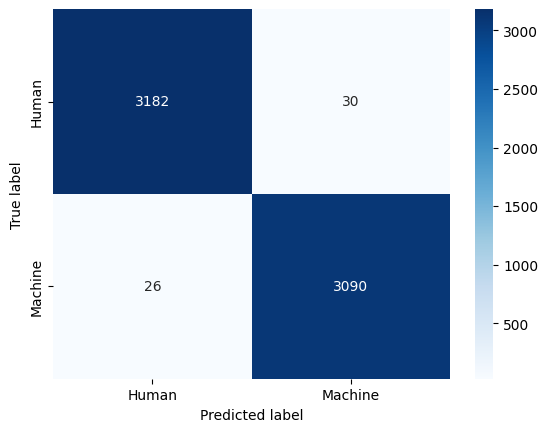

In [108]:
make_confusion_matrix(confusion_matrix(y_val, predictions_val_final), categories=categories)

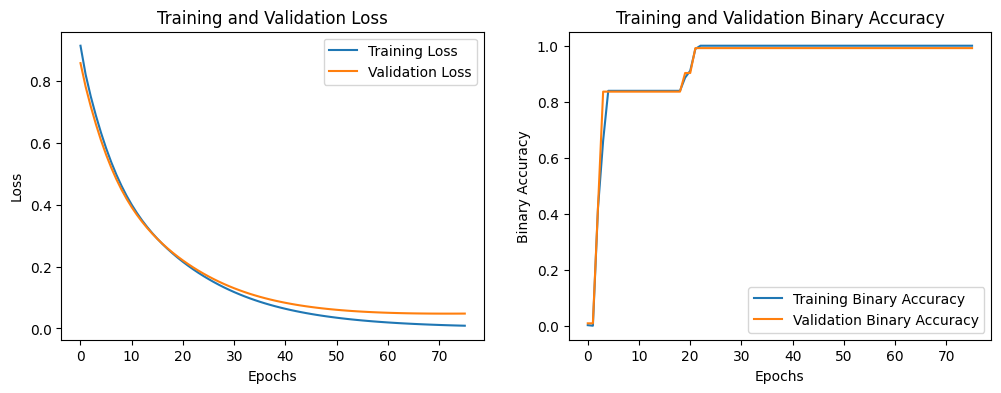

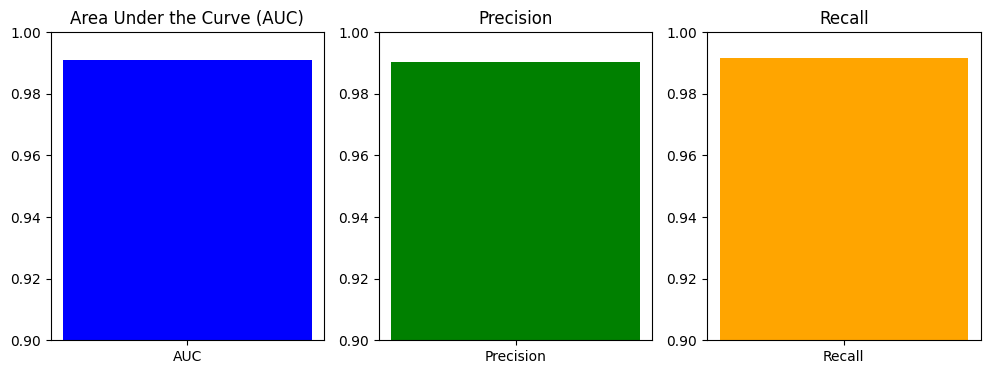

In [109]:
roc_auc = roc_auc_score(y_val, predictions_val_final)
precision = precision_score(y_val, predictions_val_final)
recall = recall_score(y_val, predictions_val_final)

# Plot della loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot della binary_accuracy
plt.subplot(1, 2, 2)
plt.plot(history_final.history['binary_accuracy'], label='Training Binary Accuracy')
plt.plot(history_final.history['val_binary_accuracy'], label='Validation Binary Accuracy')
plt.title('Training and Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()

plt.show()

# Plot dell'AUC, della Precision e del Recall
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.bar(['AUC'], [roc_auc], color=['blue'])
plt.ylim(0.9, 1)  # Imposta i limiti del range per l'AUC
plt.title('Area Under the Curve (AUC)')

plt.subplot(1, 3, 2)
plt.bar(['Precision'], [precision], color=['green'])
plt.ylim(0.9, 1)  # Imposta i limiti del range per la Precision
plt.title('Precision')

plt.subplot(1, 3, 3)
plt.bar(['Recall'], [recall], color=['orange'])
plt.ylim(0.9, 1)  # Imposta i limiti del range per il Recall
plt.title('Recall')

plt.show()